In [10]:
import tensorflow as tf
from tensorflow.python.keras import Input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.engine.keras_tensor import KerasTensor
from tensorflow.python.keras.engine.functional import Functional
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, UpSampling2D, MaxPooling2D
from tensorflow.python.keras.regularizers import l2
import os

### Import the MNIST data class and call it.

Original dataset and modified dataset with half resolution is shown below.

(100, 28, 28, 1)


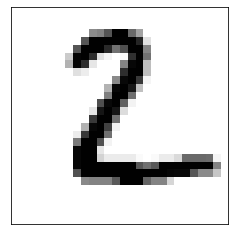

In [33]:
import MNIST_dataset as mnist
data = mnist.MNISTData(data_fraction=1/100, flat=False)
print(data.x_test.shape)

ax = plt.subplot()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(data.x_test[1].reshape(28,28), cmap='gray_r')

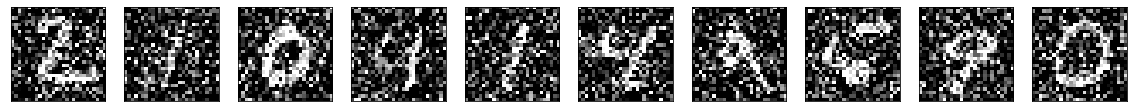

In [34]:
noise_factor = 0.5
x_train=data.x_train
x_test=data.x_test
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

(10000, 14, 14, 1)
(14, 14, 1)


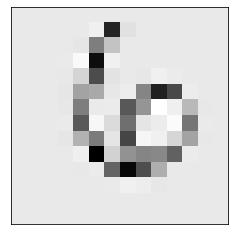

In [5]:
data_zoom = mnist.MNISTData(zoom_factor=1/2, flat=False)
test = data_zoom.x_test
print(test.shape)
ax = plt.subplot()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(test[100].reshape(14,14), cmap='gray_r')
print(test[100].shape)

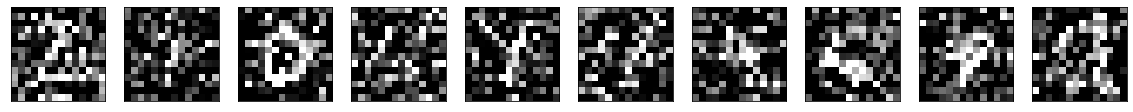

In [6]:
noise_factor = 0.5
x_train=data_zoom.x_train
x_test=data_zoom.x_test
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(14, 14))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Autoencoder using Keras
The aim of this class is to implement a simple autoencoder for the MNIST data and then build an autoencoder that is
able to classify MNIST data in its latent dimension.

Code partially adapted from [Keras Documentation](https://blog.keras.io/building-autoencoders-in-keras.html).

In [39]:
class Autoencoder:
    """Autoencoder Class"""

    def __init__(self, data: mnist.MNISTData, num_classes=10):
        self.x_train = data.x_train
        self.x_test = data.x_test
        self.y_train = data.y_train
        self.y_test = data.y_test

        self.num_classes = num_classes
        self.input_shape = self.x_train[0].shape
        self.input = Input(shape=self.input_shape, name='encoder_input')
        self.latent_dim = 2

        self.encoder = None
        self.encoder_model = None
        self.decoder = None
        self.latent_classifier = None
        self.autoencoder = None

        self.history = None

        

    def build_encoder(self):
        """Build your encoder architecture and store the output in self.encoder. 
        The final encoding dimension is 2."""
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(self.input)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        self.encoder = MaxPooling2D((2, 2), padding='same')(x)      
        
        #building a model for the encoder in order to be able to predict and plot the latent dimension
        self.encoder_model = Model(self.input, self.encoder, name='encoder')

    def build_decoder(self):
        """Build the decoder architecture."""
        if self.encoder is None:
            raise RuntimeError("The encoder has to be built before you can build the decoder!")
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(self.encoder)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        self.decoder = UpSampling2D((2, 2))(x)

    def build_classifier(self):
        """ Building the classifier architecture."""
        if self.encoder is None:
            raise RuntimeError("The encoder has to be built before you can build the classifier!")
        self.latent_classifier = Dense(50, activation='relu')(self.encoder)

        self.latent_classifier = Dense(self.num_classes, activation='softmax',name='classifier_output')(self.latent_classifier)

    def build_autoencoder(self, use_latent_classifier=False):
        """ Build the whole autoencoder Model from self.encoder and self.decoder."""
        self.dir()
        
        if self.encoder is None:
            raise RuntimeError("The encoder has to be built before you can build the autoencoder!")
        if self.decoder is None:
            raise RuntimeError("The decoder has to be built before you can build the autoencoder!")
        if use_latent_classifier:
            if self.latent_classifier is None:
                raise RuntimeError("If you want to use the option with the latent classifier, you have to build it "
                                   "beforehand!")
            self.autoencoder = Model(self.input, outputs=[self.decoder, self.latent_classifier])
            self.autoencoder.compile(loss=['mse', 'categorical_crossentropy'], loss_weights=[1, 0.1], optimizer='adam',
                                     metrics="accuracy")
            self.autoencoder.save('model/AE_model/KERAS_check_model_w_classifier.h5')

        else:
            self.autoencoder = Model(self.input, outputs=self.decoder, name = 'autoencoder')
            self.autoencoder.compile(loss='binary_crossentropy', optimizer='adam') 
            #self.autoencoder.save('model/AE_model/KERAS_check_model_wo_classifier.h5')
        self.autoencoder.summary()

    def fit_data(self, batch_size=256, epochs=40, use_latent_classifier=False):
        """Write the fit function for the autoencoder. 
        Storing the fit history in self.history to be able to plot the fitting scores."""
        if use_latent_classifier:
            self.history = self.autoencoder.fit(self.x_train, [self.x_train, self.y_train],
                                                validation_data=(self.x_test, [self.x_test, self.y_test]),
                                                batch_size=batch_size, epochs=epochs,
                                                shuffle=True,
                                                )
        else:                          
            self.history = self.autoencoder.fit(x_train_noisy, self.x_train,
                                                validation_data=(x_test_noisy, self.x_test),
                                                batch_size=batch_size, epochs=epochs,
                                                shuffle=True
                                                )

        self.history = self.history.history

    def dir(self):
        """Creation of the folders path to store the results."""
        dir = os.path.join("images")
        if not os.path.exists(dir):
            os.mkdir(dir)
        dir2 = os.path.join("./images/AE")
        if not os.path.exists(dir2):
            os.mkdir(dir2)
        dir3 = os.path.join("model")
        if not os.path.exists(dir3):
            os.mkdir(dir3)
        dir4 = os.path.join("./model/AE_model")
        if not os.path.exists(dir4):
            os.mkdir(dir4)
        
    
    def plot_score(self, model_name=None):
        """Plots the scores achieved during the fitting."""
        plt.plot(self.history['loss'])
        plt.plot(self.history['val_loss'])
        plt.ylabel('Model Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='best')
        plt.title('Accuracy of {model_name}'.format(model_name=model_name))
        
        plt.savefig('./images/AE/Accuracy of {model_name}.png'.format(model_name=model_name))
        
        plt.show()

    def plot_latent_dimension(self, model_name = None):
        """Plots the latent dimension of the autoencoder."""
        prediction = self.encoder_model.predict(self.x_test)
        fig = plt.figure(figsize=(10, 10))
        fig.patch.set_facecolor("white")
        plt.scatter(prediction[:, 0], prediction[:, 1], c=np.argmax(self.y_test, axis=1), cmap="Set3")
        plt.colorbar()
        plt.title('Latent space {model_name}'.format(model_name=model_name))


        plt.savefig('./images/AE/Latent dimension of {model_name}.png'.format(model_name=model_name))

        plt.show()

    def plot_reco(self, use_latent_classifier = False):
        """Plotting reconstructed images"""
        
        n = 6
        plt.figure(figsize=(10, 3))
        reco_imgs = self.autoencoder.predict(x_train_noisy)
        
        if use_latent_classifier :
            raise RuntimeError("You are considering the autoencoder with classifier!")
        else:
        
            for i in range(n):
                # Display original MNIST
                ax = plt.subplot(2, n, i + 1)
                plt.imshow(self.x_test[i], cmap='gray_r')
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

                # Display reconstructed MNIST            
                ax = plt.subplot(2, n, i + n + 1)
                plt.imshow(reco_imgs[i], cmap='gray_r')
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            plt.savefig('./images/AE/reconstructed images.png')
            plt.show()
 


It is built the standard autoencoder, *without classifier* here, and the MNIST data class called before is used. 
The model is fitted and adequate plots are reproduced, 
as well as the comparison between orginal MNIST dataset and reconstructed images.

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_14 (UpSampling (None, 14, 14, 32)        

ValueError: 'c' argument has 100 elements, which is inconsistent with 'x' and 'y' with size 22400.

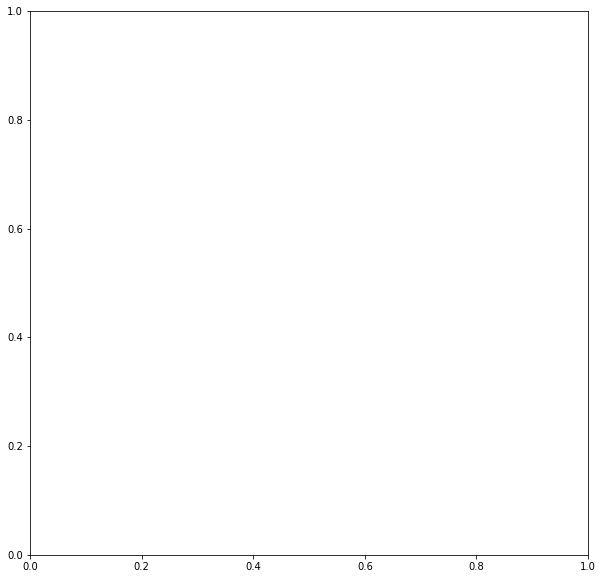

In [40]:
network = Autoencoder(data)
network.build_encoder()
network.build_decoder()
network.build_autoencoder()
network.fit_data(epochs=40)
network.plot_latent_dimension("Autoencoder without classifier")
network.plot_reco()
network.plot_score("Autoencoder without classifier")


Repeating the same procedure for the autoencoder with classifier.

Model: "functional_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 196)]        0                                            
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 49)           9653        encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_output (Dense)          (None, 2)            100         dense_24[0][0]                   
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 49)           147         encoder_output[0][0]             
______________________________________________________________________________________

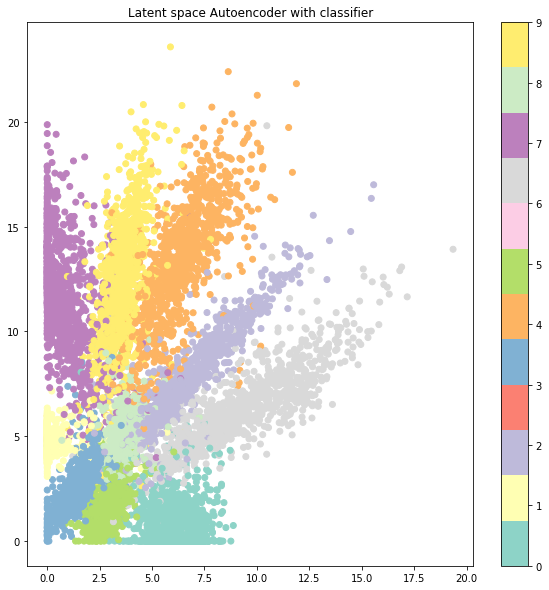

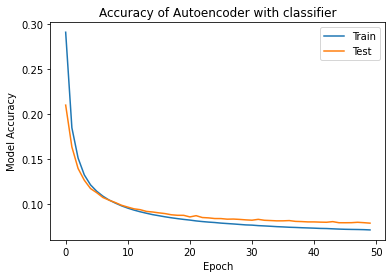

In [27]:
network_with_classifier = Autoencoder(data_zoom)
network_with_classifier.build_encoder()
network_with_classifier.build_decoder()
network_with_classifier.build_classifier()
network_with_classifier.build_autoencoder(use_latent_classifier=True)
network_with_classifier.fit_data(epochs=50, use_latent_classifier=True)
network_with_classifier.plot_latent_dimension("Autoencoder with classifier")
network_with_classifier.plot_score("Autoencoder with classifier")